## Create a predictive model for amzn stock.


We first download the adjusted AMZN stock prices from the alpha-vantage website. If you wish to do this yourself please enter an appropriate api_key.

In [94]:
def load_amzn_data():
    import requests
    import pandas as pd

    url = "https://www.alphavantage.co/query"
    api_key = "XXXXXXXXXXXXXXX"
    symbol = "AMZN"
    function = "TIME_SERIES_DAILY_ADJUSTED"
    outputsize = "full"
    api_params = {"apikey": api_key,
                  "symbol": symbol,
                  "function": function,
                  "outputsize": outputsize
                  }
    url_data = requests.get(url, params=api_params)
    # Check URL corrrectly encoded
    #print(url_data.url)

    jdata = url_data.json()
    data_series = list(jdata.keys())[1]
    df = pd.DataFrame(jdata[data_series]).T
    # Convert object data to float
    df[df.select_dtypes(['object']).columns] = df.select_dtypes([
        'object']).apply(lambda x: x.astype('float'))
    df.columns = [
        'Open',
        'High',
        'Low',
        'Close',
        'AdjClose',
        'Volume',
        'DividendAmt',
        'SplitCoeff']
    # Drop these columns as they're not needed
    df.drop(['DividendAmt', 'SplitCoeff'], inplace=True, axis=1)
    df['Volume'] = df['Volume'].astype(int)
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index)
    return df


In [95]:
import pandas as pd
import numpy as np

In [96]:
df_amzn=load_amzn_data()


Plot price and volume data. Note that the fact we've plotted and seen all the data means there is already a potential bias introduced for any predictive model in that we now know the most recent data (which would normally be used as out of sample data) exhibits a sharp rise in price.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_amzn(df_amzn):
    # Price
    price_plt = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
    price_plt.plot(df_amzn.index, df_amzn['AdjClose'],
                   label='AMZN AdjClose')
    plt.title('AMZN AdjClose Price 2000 - 2018')
    plt.legend(loc=2)

    # Volume
    volume_plt = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4)
    volume_plt.bar(df_amzn.index, df_amzn['Volume'])
    plt.title('AMZN Trading Volume 2000 - 2018')
    plt.subplots_adjust(hspace=0.75)
    plt.gcf().set_size_inches(15, 8)
    plt.ylim(0, 3.5e7)

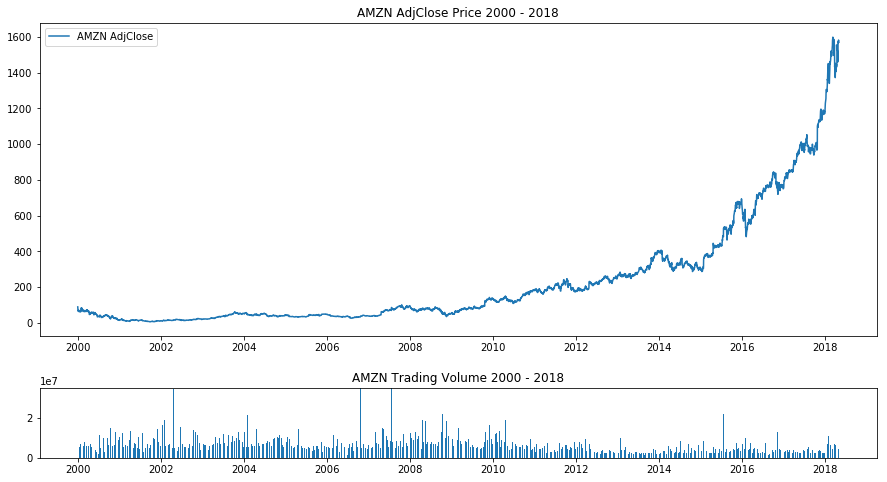

In [5]:
plot_amzn(df_amzn)

Plot log of price

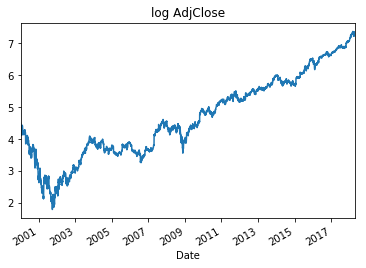

In [7]:

np.log(df_amzn.AdjClose).plot(title='log AdjClose');

In [8]:
df_amzn.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2000-01-03,81.50,89.56,80.00,89.38,89.38,16117600
2000-01-04,85.38,91.50,81.75,81.94,81.94,17487400
2000-01-05,70.75,75.13,69.63,71.75,71.75,38457400
2000-01-06,71.31,72.69,64.00,65.56,65.56,18752000
2000-01-07,67.00,70.50,66.19,69.56,69.56,10505400


In [9]:
df_amzn.dtypes

Open        float64
High        float64
Low         float64
Close       float64
AdjClose    float64
Volume        int32
dtype: object

In [10]:
#  save data to disk if desired
#  df_amzn.to_csv('amzn.csv')

Here I choose to resample the daily amzn data to yearly given that the WGEM data from quandl is yearly. It's important to do this correctly in order that the final model doesn't suffer from, 'future leaks'.

In [11]:
def annualise_amzn(df):
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'AdjClose': 'last',
        'Volume': 'sum'}
    #  BA business year end frequency
    return df.resample('BA',closed='right',label='right').apply(ohlc_dict).copy()

In [12]:
df_amzn_annual=annualise_amzn(df_amzn)

In [13]:
df_amzn_annual.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2000-12-29,81.50,91.50,14.88,15.56,15.56,2.207008e+09
2001-12-31,15.81,22.38,5.51,10.82,10.82,2.109573e+09
2002-12-31,10.94,25.00,9.03,18.89,18.89,2.111409e+09
2003-12-31,19.19,61.15,18.55,52.62,52.62,2.277856e+09
2004-12-31,52.76,57.82,33.00,44.29,44.29,2.144232e+09


In [14]:
df_amzn_annual.index

DatetimeIndex(['2000-12-29', '2001-12-31', '2002-12-31', '2003-12-31',
               '2004-12-31', '2005-12-30', '2006-12-29', '2007-12-31',
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-30',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-30', '2017-12-29', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', freq='BA-DEC')

Due to time constraints I'm going to use 1 year percentage change of price as the dependent variable.Calculate and add pct_change of AdjClose to annual data. Use shift(-1) to make it easier to use in prediction model as target/depedent variable.

In [15]:
df_amzn_annual['AdjClose_pchg']=df_amzn_annual['AdjClose'].pct_change().shift(-1).fillna(0)

Here we download a csv file of quandl codes for the WGEM data from the quandl site.

In [19]:
def load_wgem_codes():
    import pandas as pd
    import requests
    import zipfile
    import io
    url = 'https://www.quandl.com/api/v3/databases/WGEM/codes?api_key=XXXXXXXXXXXXXXXXXXXXXX'
    url_data = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(url_data.content))
    name = z.namelist()[0]
    df_wgem_codes = pd.read_csv(
        io.BytesIO(
            z.read(name)),
        header=None,
        index_col='code',
        names=[
            'code',
            'series_name'],
        encoding='utf8')
    z.close()
    return df_wgem_codes

In [20]:
df_wgem_codes=load_wgem_codes()

Obtain index to US series only.

In [21]:
us_indx=df_wgem_codes.series_name.str.contains('United States')

In [22]:
df_wgem_codes[us_indx].sort_index()

,series_name
code,
WGEM/USA_CPTOTNSXN,"CPI Price, nominal - United States"
WGEM/USA_CPTOTSAXN,"CPI Price, nominal, seas. adj. - United States"
WGEM/USA_CPTOTSAXNZGY,"CPI Price, % y-o-y, nominal, seas. adj. - Unit..."
WGEM/USA_DMGSRMRCHNSCD,"Imports Merchandise, Customs, current US$, mil..."
WGEM/USA_DMGSRMRCHNSKD,"Imports Merchandise, Customs, constant US$, mi..."
WGEM/USA_DMGSRMRCHNSXD,"Imports Merchandise, Customs, Price, US$ - Uni..."
WGEM/USA_DMGSRMRCHSACD,"Imports Merchandise, Customs, current US$, mil..."
WGEM/USA_DMGSRMRCHSAKD,"Imports Merchandise, Customs, constant US$, mi..."
WGEM/USA_DMGSRMRCHSAXD,"Imports Merchandise, Customs, Price, US$, seas..."


Download the US WGEM series from quandl.

In [23]:
def load_wgem_series(df_wgem_codes):
    import quandl
    import collections
    quandl.ApiConfig.api_key = "XXXXXXXXXXXXXXX"    
    codes=list(df_wgem_codes[us_indx].sort_index().index)    
    ord_dict = collections.OrderedDict()
    for code in codes:
        ord_dict[code] = quandl.get(code)
    ord_dict = collections.OrderedDict(sorted(ord_dict.items()))
    return ord_dict

In [24]:
wgem_odict=load_wgem_series(df_wgem_codes)

In [25]:
wgem_odict.keys()

odict_keys(['WGEM/USA_CPTOTNSXN', 'WGEM/USA_CPTOTSAXN', 'WGEM/USA_CPTOTSAXNZGY', 'WGEM/USA_DMGSRMRCHNSCD', 'WGEM/USA_DMGSRMRCHNSKD', 'WGEM/USA_DMGSRMRCHNSXD', 'WGEM/USA_DMGSRMRCHSACD', 'WGEM/USA_DMGSRMRCHSAKD', 'WGEM/USA_DMGSRMRCHSAXD', 'WGEM/USA_DPANUSLCU', 'WGEM/USA_DPANUSSPB', 'WGEM/USA_DPANUSSPF', 'WGEM/USA_DSTKMKTXD', 'WGEM/USA_DSTKMKTXN', 'WGEM/USA_DXGSRMRCHNSCD', 'WGEM/USA_DXGSRMRCHNSKD', 'WGEM/USA_DXGSRMRCHNSXD', 'WGEM/USA_DXGSRMRCHSACD', 'WGEM/USA_DXGSRMRCHSAKD', 'WGEM/USA_DXGSRMRCHSAXD', 'WGEM/USA_IMPCOV', 'WGEM/USA_IPTOTNSKD', 'WGEM/USA_IPTOTSAKD', 'WGEM/USA_NEER', 'WGEM/USA_REER', 'WGEM/USA_TOTRESV'])

Remove the most recent 2018 data point from data series and store the start year of the shortest data series (Having checked the World Bank Data website the 2018 data points are just summations of the most recently available 2018 monthly figures).

In [26]:
def drop_latest(ord_dict):
    latest_start = 0
    for i, (key, value) in enumerate(ord_dict.items()):
        print(i, key, value.tail(1).index[-1].year)
        if(value.index[-1].year == 2018):
            value.drop(value.index[-1], inplace=True)
        start_year = value.index[0].year
        if(latest_start < start_year):
            latest_start = start_year
    return latest_start

In [27]:
latest_start=drop_latest(wgem_odict)

0 WGEM/USA_CPTOTNSXN 2018
1 WGEM/USA_CPTOTSAXN 2018
2 WGEM/USA_CPTOTSAXNZGY 2018
3 WGEM/USA_DMGSRMRCHNSCD 2017
4 WGEM/USA_DMGSRMRCHNSKD 2017
5 WGEM/USA_DMGSRMRCHNSXD 2018
6 WGEM/USA_DMGSRMRCHSACD 2017
7 WGEM/USA_DMGSRMRCHSAKD 2017
8 WGEM/USA_DMGSRMRCHSAXD 2018
9 WGEM/USA_DPANUSLCU 2018
10 WGEM/USA_DPANUSSPB 2018
11 WGEM/USA_DPANUSSPF 2018
12 WGEM/USA_DSTKMKTXD 2018
13 WGEM/USA_DSTKMKTXN 2018
14 WGEM/USA_DXGSRMRCHNSCD 2017
15 WGEM/USA_DXGSRMRCHNSKD 2017
16 WGEM/USA_DXGSRMRCHNSXD 2018
17 WGEM/USA_DXGSRMRCHSACD 2017
18 WGEM/USA_DXGSRMRCHSAKD 2017
19 WGEM/USA_DXGSRMRCHSAXD 2018
20 WGEM/USA_IMPCOV 2017
21 WGEM/USA_IPTOTNSKD 2018
22 WGEM/USA_IPTOTSAKD 2018
23 WGEM/USA_NEER 2018
24 WGEM/USA_REER 2018
25 WGEM/USA_TOTRESV 2017


Plot all US WGEM data series.

In [28]:
def plot_wgem_data(ord_dict,wgem):
    import matplotlib.pyplot as plt
    from palettable.tableau import Tableau_10
    import itertools

    color_list = Tableau_10.hex_colors
    c = itertools.cycle(color_list)

    data_codes = list(ord_dict.keys())
    width=3
    height=int(np.ceil(len(ord_dict)/3))
    fig, axs = plt.subplots(height, width, figsize=(22, 26))
    plt.subplots_adjust(hspace=0.3)
    for ax, code in zip(axs.ravel(), data_codes):
        ax.plot(
            ord_dict[code].index,
            ord_dict[code].values,
            color=next(c),
            linewidth=4.0)
        name = wgem.series_name[wgem.index == code][0]
        s_name = ''.join(name.split(',')[0:2])
        ax.text(0.5, 1.06, s_name,
                horizontalalignment='center',
                fontsize=18,
                transform=ax.transAxes)
    plt.show()

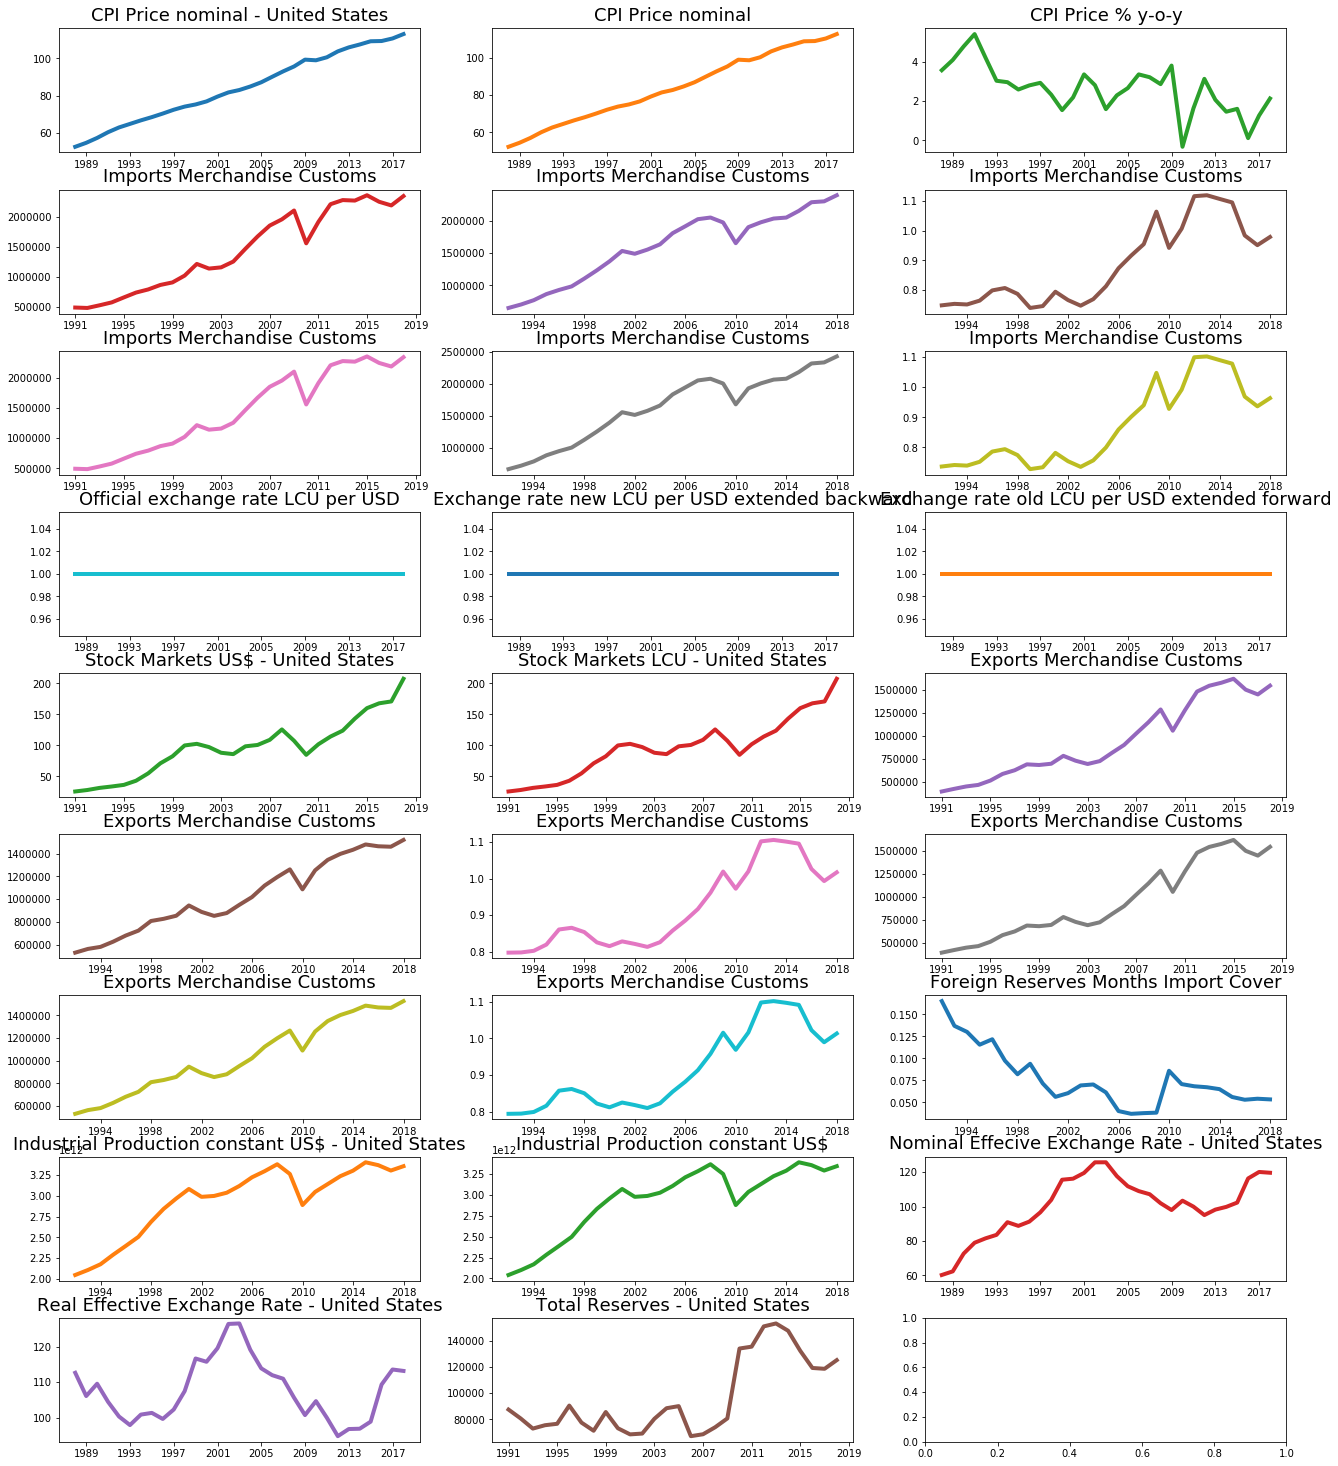

In [30]:
plot_wgem_data(wgem_odict,df_wgem_codes)

Drop what are obvious near duplicates (mainly the seasonally adjusted versions) and those with only one unique value i.e., 'Official Exchange Rate LCU'. Later we'll do this more formally by checking correlations of the differenced data.

In [31]:
del wgem_odict['WGEM/USA_DPANUSLCU']
del wgem_odict['WGEM/USA_DPANUSSPB']
del wgem_odict['WGEM/USA_DPANUSSPF']
del wgem_odict['WGEM/USA_CPTOTSAXN']
del wgem_odict['WGEM/USA_CPTOTSAXNZGY']  
del wgem_odict['WGEM/USA_DXGSRMRCHSACD']
del wgem_odict['WGEM/USA_DXGSRMRCHSAKD']
del wgem_odict['WGEM/USA_DXGSRMRCHSAXD']
del wgem_odict['WGEM/USA_DMGSRMRCHSACD']
del wgem_odict['WGEM/USA_DMGSRMRCHSAKD']
del wgem_odict['WGEM/USA_DMGSRMRCHSAXD']
del wgem_odict['WGEM/USA_DSTKMKTXN']
del wgem_odict['WGEM/USA_IPTOTSAKD']

In [32]:
wgem_odict.keys()

odict_keys(['WGEM/USA_CPTOTNSXN', 'WGEM/USA_DMGSRMRCHNSCD', 'WGEM/USA_DMGSRMRCHNSKD', 'WGEM/USA_DMGSRMRCHNSXD', 'WGEM/USA_DSTKMKTXD', 'WGEM/USA_DXGSRMRCHNSCD', 'WGEM/USA_DXGSRMRCHNSKD', 'WGEM/USA_DXGSRMRCHNSXD', 'WGEM/USA_IMPCOV', 'WGEM/USA_IPTOTNSKD', 'WGEM/USA_NEER', 'WGEM/USA_REER', 'WGEM/USA_TOTRESV'])

Re-plot but this time using natural log.

In [33]:
def plot_wgem_ln_data(ord_dict,wgem):
    import matplotlib.pyplot as plt
    from palettable.tableau import Tableau_10
    import itertools

    color_list = Tableau_10.hex_colors
    c = itertools.cycle(color_list)

    data_codes = list(ord_dict.keys())
    width=3
    height=int(np.ceil(len(ord_dict)/3))
    fig, axs = plt.subplots(height, width, figsize=(22, 26))
    plt.subplots_adjust(hspace=0.3)
    for ax, code in zip(axs.ravel(), data_codes):
        ax.plot(
            ord_dict[code].index,
            np.log(
                ord_dict[code].values),
            color=next(c),
            linewidth=4.0)
        name = wgem.series_name[wgem.index == code][0]
        s_name = ''.join(name.split(',')[0:2])
        ax.text(0.5, 1.06, s_name,
                horizontalalignment='center',
                fontsize=18,
                transform=ax.transAxes)
    plt.show()


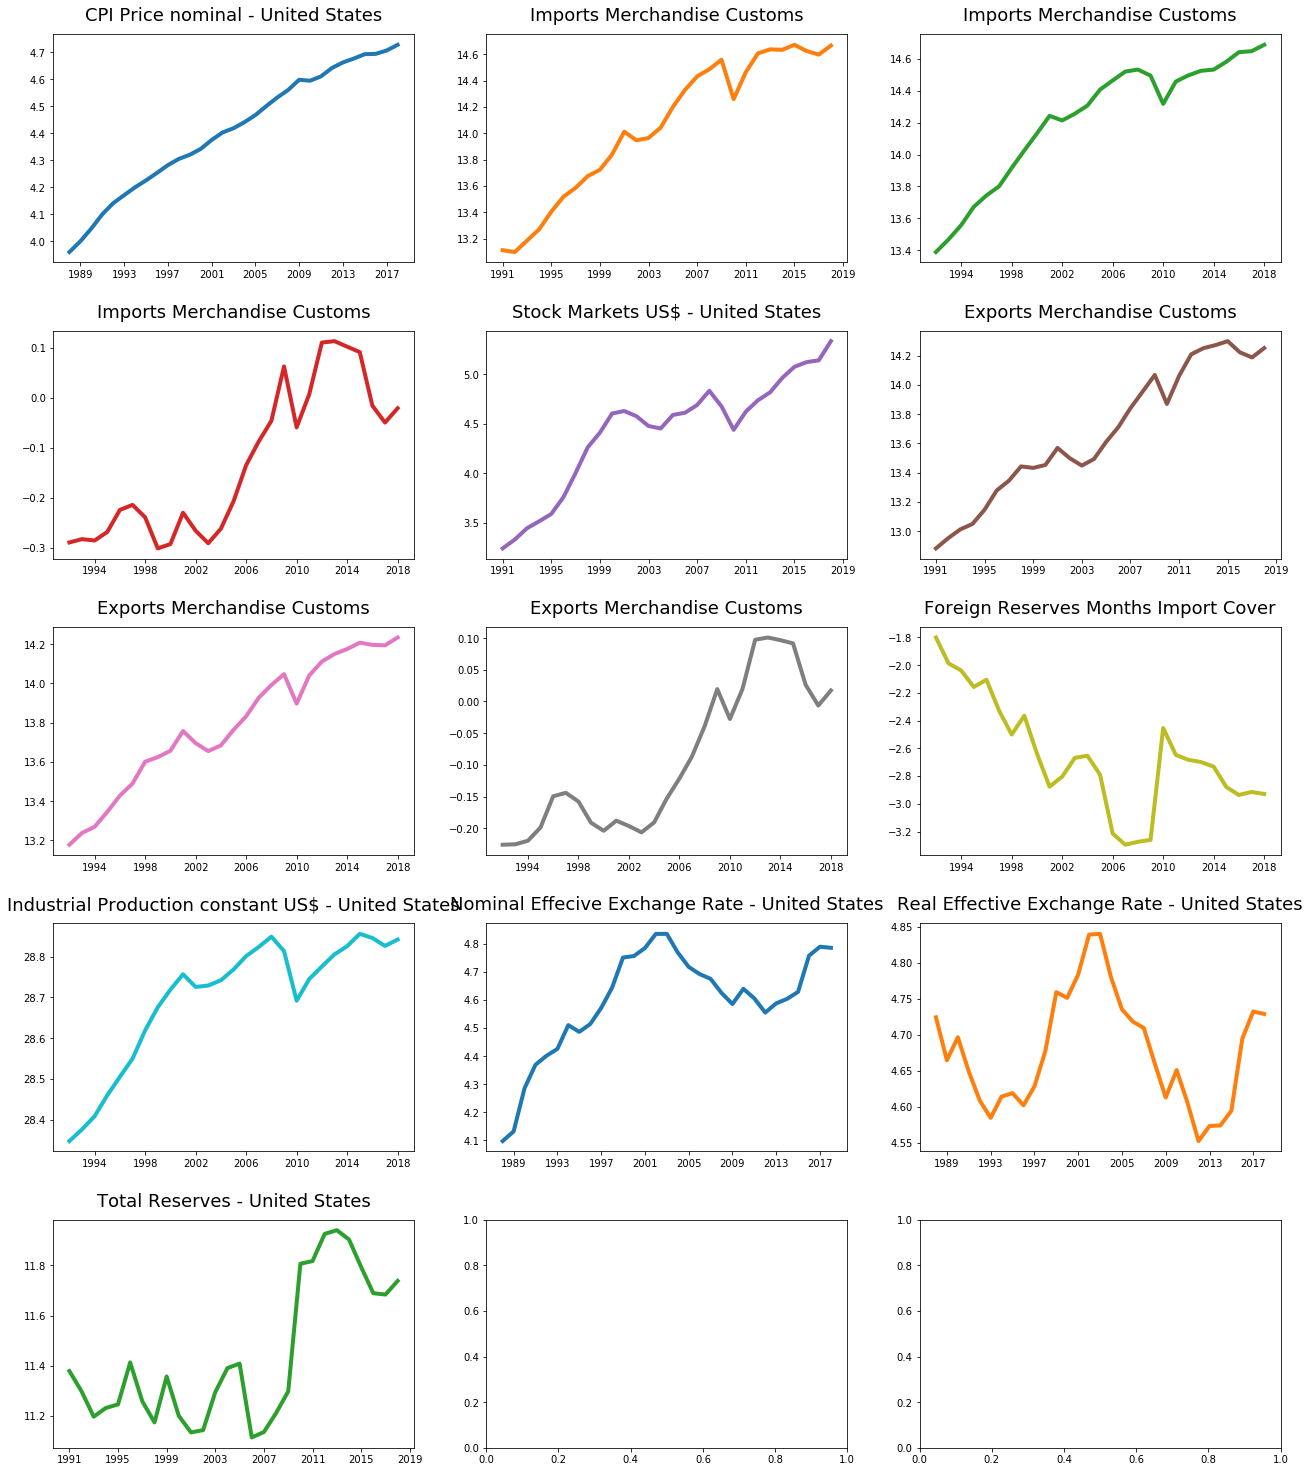

In [35]:
plot_wgem_ln_data(wgem_odict,df_wgem_codes)

Clean up the series names. 

In [36]:
#This is messy, should probably just type out names in a list
import re
data_codes=list(wgem_odict.keys())
series_names=list(df_wgem_codes.loc[data_codes].series_name.values)


s_names=[]
li=re.split('[-,]',series_names[0])
s_names.append(''.join([li[0],' ',li[1].strip()]))
li=re.split('[-, ]',series_names[1])
s_names.append(''.join([li[0],' ',li[5]]))
li=re.split('[-, ]',series_names[2])
s_names.append(''.join([li[0],' ',li[5]]))
li=re.split('[-, ]',series_names[3])
s_names.append(''.join([li[0],' ',li[5]]))
s_names.append(re.split('[,]',series_names[4])[0])
li=re.split('[-, ]',series_names[5])
s_names.append(''.join([li[0],' ',li[5]]))
li=re.split('[-, ]',series_names[6])
s_names.append(''.join([li[0],' ',li[5]]))
li=re.split('[-, ]',series_names[7])
s_names.append(''.join([li[0],' ',li[5]]))
s_names.append(re.split('[,]',series_names[8])[0])
s_names.append(re.split('[,]',series_names[9])[0])
li=re.split('[ ]',series_names[10])
s_names.append(''.join([li[0],' ',li[2],' ',li[3]]))
li=re.split('[ ]',series_names[11])
s_names.append(''.join([li[0],' ',li[2],' ',li[3]]))
s_names.append(re.split('[-]',series_names[12])[0].strip())

In [37]:
s_names

['CPI Price nominal',
 'Imports current',
 'Imports constant',
 'Imports Price',
 'Stock Markets',
 'Exports current',
 'Exports constant',
 'Exports Price',
 'Foreign Reserves',
 'Industrial Production',
 'Nominal Exchange Rate',
 'Real Exchange Rate',
 'Total Reserves']

In [38]:
data_codes

['WGEM/USA_CPTOTNSXN',
 'WGEM/USA_DMGSRMRCHNSCD',
 'WGEM/USA_DMGSRMRCHNSKD',
 'WGEM/USA_DMGSRMRCHNSXD',
 'WGEM/USA_DSTKMKTXD',
 'WGEM/USA_DXGSRMRCHNSCD',
 'WGEM/USA_DXGSRMRCHNSKD',
 'WGEM/USA_DXGSRMRCHNSXD',
 'WGEM/USA_IMPCOV',
 'WGEM/USA_IPTOTNSKD',
 'WGEM/USA_NEER',
 'WGEM/USA_REER',
 'WGEM/USA_TOTRESV']

I'm going to use simple one period percentage changes as independent variables. The reasoning is that most if not all the data is likely non-stationary (has a unit root) and therefore isn't suitable in its present form to include in a regression model.

Create dataframe of percentage change.

In [39]:
def df_pct_chg(ord_dict):
    df_pct_chg = pd.DataFrame(index=list(ord_dict.values())[0].index)
    df_pct_chg = df_pct_chg.loc[str(latest_start):]
    for i, (key, value) in enumerate(ord_dict.items()):
        df_pct_chg[s_names[i]] = value.pct_change().fillna(0)
    return df_pct_chg

In [40]:
data_pct_chg=df_pct_chg(wgem_odict)

Boxplot. There don't seem to be any nasty outliers.

In [41]:
def  plot_boxplot(df):
    import pandas as pd
    df.boxplot();
    plt.title('Boxplot')
    plt.ylim(-0.4,0.6 );
    plt.xticks(rotation=90);

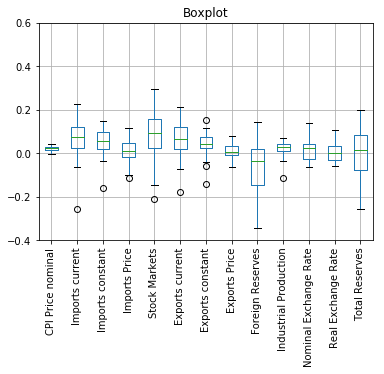

In [42]:
plot_boxplot(data_pct_chg)

Prepare data for linear regression model. Drop the 2018 data row for amzn annual data and make sure both dataframes start at 2000.

In [43]:
df_amzn_annual.head()

,Open,High,Low,Close,AdjClose,Volume,AdjClose_pchg
Date,,,,,,,
2000-12-29,81.50,91.50,14.88,15.56,15.56,2.207008e+09,-0.304627
2001-12-31,15.81,22.38,5.51,10.82,10.82,2.109573e+09,0.745841
2002-12-31,10.94,25.00,9.03,18.89,18.89,2.111409e+09,1.785601
2003-12-31,19.19,61.15,18.55,52.62,52.62,2.277856e+09,-0.158305
2004-12-31,52.76,57.82,33.00,44.29,44.29,2.144232e+09,0.064574


In [44]:
df_amzn_annual.drop(df_amzn_annual.index[-1],inplace=True)
data_pct_chg=data_pct_chg.loc['2000':]
df_amzn_annual.set_index(data_pct_chg.index,inplace=True)

In [45]:
data_pct_chg.head()

,CPI Price nominal,Imports current,Imports constant,Imports Price,Stock Markets,Exports current,Exports constant,Exports Price,Foreign Reserves,Industrial Production,Nominal Exchange Rate,Real Exchange Rate,Total Reserves
Date,,,,,,,,,,,,,
2000-12-31,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777
2001-12-31,0.028262,-0.063237,-0.028520,-0.035417,-0.050842,-0.067549,-0.059841,-0.008417,0.075121,-0.030755,0.051620,0.056991,0.009152
2002-12-31,0.015860,0.017851,0.043063,-0.024708,-0.094482,-0.049375,-0.039605,-0.009917,0.144579,0.003637,0.000221,0.001029,0.162985
2003-12-31,0.022701,0.082450,0.052455,0.029498,-0.025236,0.045692,0.029254,0.015873,0.015926,0.012862,-0.063943,-0.058336,0.100306
2004-12-31,0.026772,0.169104,0.105355,0.056359,0.147194,0.124321,0.082496,0.038519,-0.128191,0.026832,-0.050127,-0.043757,0.018213


In [46]:
ols_data=pd.concat([df_amzn_annual[['AdjClose_pchg']],data_pct_chg], axis=1)

In [47]:
ols_data.head()

,AdjClose_pchg,CPI Price nominal,Imports current,Imports constant,Imports Price,Stock Markets,Exports current,Exports constant,Exports Price,Foreign Reserves,Industrial Production,Nominal Exchange Rate,Real Exchange Rate,Total Reserves
Date,,,,,,,,,,,,,,
2000-12-31,-0.304627,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777
2001-12-31,0.745841,0.028262,-0.063237,-0.028520,-0.035417,-0.050842,-0.067549,-0.059841,-0.008417,0.075121,-0.030755,0.051620,0.056991,0.009152
2002-12-31,1.785601,0.015860,0.017851,0.043063,-0.024708,-0.094482,-0.049375,-0.039605,-0.009917,0.144579,0.003637,0.000221,0.001029,0.162985
2003-12-31,-0.158305,0.022701,0.082450,0.052455,0.029498,-0.025236,0.045692,0.029254,0.015873,0.015926,0.012862,-0.063943,-0.058336,0.100306
2004-12-31,0.064574,0.026772,0.169104,0.105355,0.056359,0.147194,0.124321,0.082496,0.038519,-0.128191,0.026832,-0.050127,-0.043757,0.018213


Visualise correlation matrix of variables. It can be seen that many of the remaining variables are highly correlated. What is also apparent is the weak lag 1 correlation between the dependent AdjClose_pchg and independent variables (faint red and blue squares).

In [48]:
def plot_corr_matrix(df):
    import seaborn as sns
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(11, 11))
    sns.set(font_scale=1.2)
    with sns.axes_style("white"):
        ax = sns.heatmap(
            corr,
            cmap="bwr",
            cbar_kws={
                "shrink": .7},
            mask=mask,
            vmax=.8,
            square=True)
    return corr

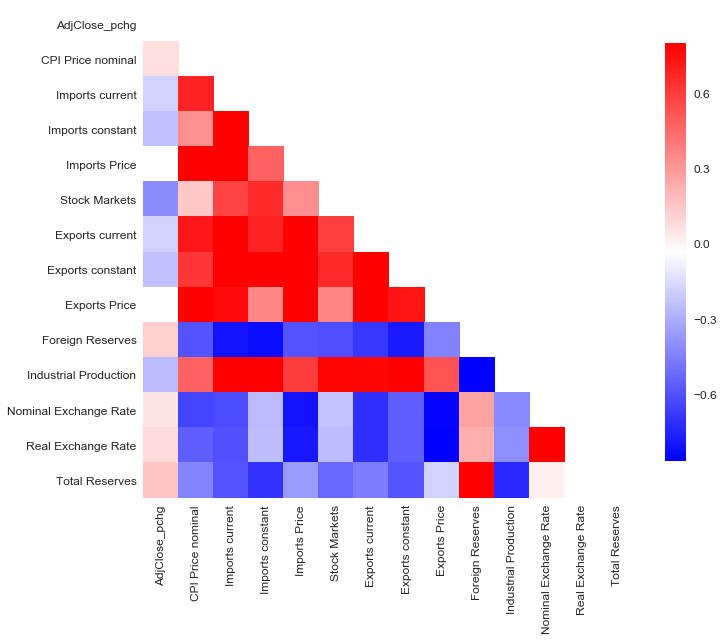

In [49]:
corr=plot_corr_matrix(ols_data)

In [50]:
corr

,AdjClose_pchg,CPI Price nominal,Imports current,Imports constant,Imports Price,Stock Markets,Exports current,Exports constant,Exports Price,Foreign Reserves,Industrial Production,Nominal Exchange Rate,Real Exchange Rate,Total Reserves
AdjClose_pchg,1.000000,0.076950,-0.177102,-0.240024,-0.034019,-0.410507,-0.176505,-0.239615,-0.029654,0.120501,-0.255641,0.053277,0.078595,0.155624
CPI Price nominal,0.076950,1.000000,0.685484,0.331264,0.869291,0.146722,0.726917,0.619971,0.805125,-0.590029,0.476008,-0.638722,-0.558492,-0.430952
Imports current,-0.177102,0.685484,1.000000,0.862490,0.856813,0.575281,0.933209,0.942813,0.762162,-0.806403,0.862549,-0.621884,-0.600237,-0.594097
Imports constant,-0.240024,0.331264,0.862490,1.000000,0.481272,0.657802,0.683315,0.804862,0.362936,-0.826341,0.889622,-0.260655,-0.241495,-0.697520
Imports Price,-0.034019,0.869291,0.856813,0.481272,1.000000,0.333441,0.922590,0.818186,0.950336,-0.594013,0.603873,-0.804349,-0.786734,-0.359992
Stock Markets,-0.410507,0.146722,0.575281,0.657802,0.333441,1.000000,0.591926,0.666192,0.369934,-0.607775,0.784802,-0.231905,-0.252036,-0.526150
Exports current,-0.176505,0.726917,0.933209,0.683315,0.922590,0.591926,1.000000,0.964248,0.889527,-0.686606,0.774327,-0.710370,-0.714948,-0.460231
Exports constant,-0.239615,0.619971,0.942813,0.804862,0.818186,0.666192,0.964248,1.000000,0.737442,-0.776110,0.847570,-0.555829,-0.560074,-0.592015
Exports Price,-0.029654,0.805125,0.762162,0.362936,0.950336,0.369934,0.889527,0.737442,1.000000,-0.438473,0.532687,-0.859724,-0.860011,-0.179308
Foreign Reserves,0.120501,-0.590029,-0.806403,-0.826341,-0.594013,-0.607775,-0.686606,-0.776110,-0.438473,1.000000,-0.866292,0.271423,0.229322,0.940017


Ordinarily we would spend a lot more time analysing the potential underlying economic and fundamental relationships within this data set. 

It can also be useful to observe the auto-correlation of variables. Given the small data set it's not surprising the lagged auto-correlation figures below are not significant - except perhaps for the lag1 AdjClose at ~ -0.5.

In [51]:
def plot_data_acf(df):
    from statsmodels.graphics.tsaplots import plot_acf
    import itertools
    fig, axs = plt.subplots(5, 3, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3)
    for ax, col in zip(axs.ravel(), df.columns):
        s_name = 'Autocorrelation' + '\n' + col
        plot_acf(df[col], ax=ax, title=s_name, lags=10)
    plt.show()

F:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


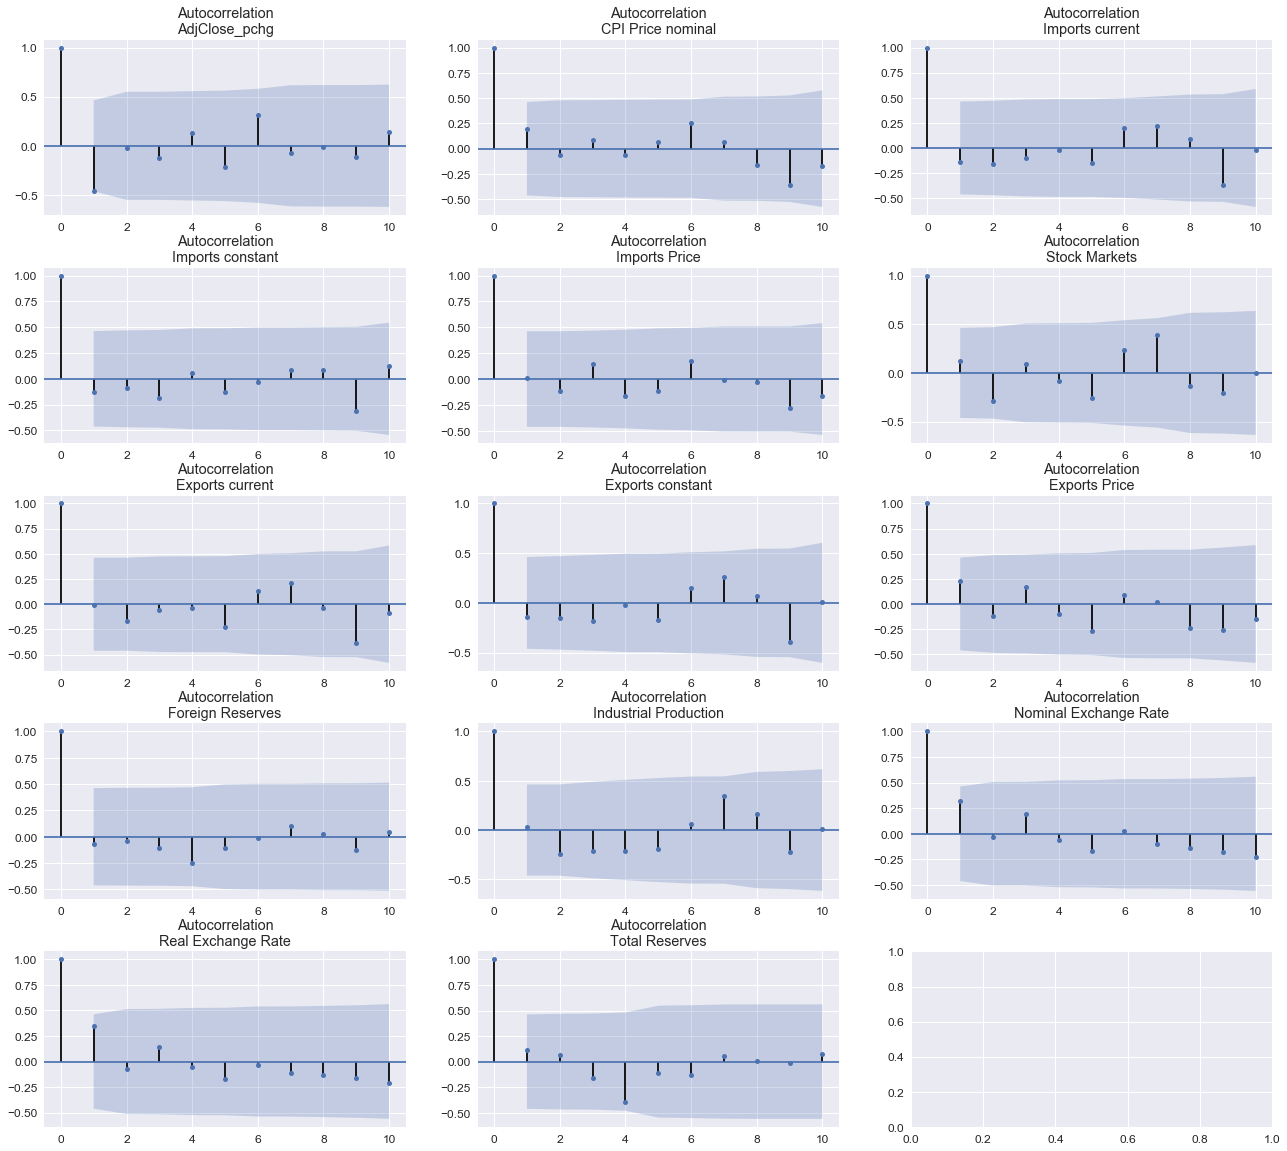

In [52]:
plot_data_acf(ols_data)

Fitting an OLS model with many highly correlated variables (multicollinearity) is often problematic so at this stage we'll just perform a forward-backward feature selection algorithm. 

NOTE: With only circa 20 data points this is an exercise in over-fitting. We'll proceed nonetheless.

I use slightly edited code from
https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

In [53]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


X = data_pct_chg
y = ols_data.AdjClose_pchg.values


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.6, 
                       threshold_out = 0.8, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return excluded

result = stepwise_selection(X, y)

print('resulting features to exclude:')
print(result)

Add  Stock Markets                  with p-value 0.0906199
Add  Foreign Reserves               with p-value 0.49394
Add  Total Reserves                 with p-value 0.412134
Add  Imports current                with p-value 0.116226
resulting features to exclude:
['Exports current', 'Industrial Production', 'Exports constant', 'CPI Price nominal', 'Real Exchange Rate', 'Exports Price', 'Imports constant', 'Imports Price', 'Nominal Exchange Rate']


So we exclude these variables

In [54]:
result

['Exports current',
 'Industrial Production',
 'Exports constant',
 'CPI Price nominal',
 'Real Exchange Rate',
 'Exports Price',
 'Imports constant',
 'Imports Price',
 'Nominal Exchange Rate']

In [55]:
ols_data.drop(result,axis=1,inplace=True)

In [56]:
ols_data.corr()

,AdjClose_pchg,Imports current,Stock Markets,Foreign Reserves,Total Reserves
AdjClose_pchg,1.000000,-0.177102,-0.410507,0.120501,0.155624
Imports current,-0.177102,1.000000,0.575281,-0.806403,-0.594097
Stock Markets,-0.410507,0.575281,1.000000,-0.607775,-0.526150
Foreign Reserves,0.120501,-0.806403,-0.607775,1.000000,0.940017
Total Reserves,0.155624,-0.594097,-0.526150,0.940017,1.000000


In [57]:
ols_data

,AdjClose_pchg,Imports current,Stock Markets,Foreign Reserves,Total Reserves
Date,,,,,
2000-12-31,-0.304627,0.188761,0.025803,-0.212569,-0.063777
2001-12-31,0.745841,-0.063237,-0.050842,0.075121,0.009152
2002-12-31,1.785601,0.017851,-0.094482,0.144579,0.162985
2003-12-31,-0.158305,0.082450,-0.025236,0.015926,0.100306
2004-12-31,0.064574,0.169104,0.147194,-0.128191,0.018213
2005-12-31,-0.163097,0.138633,0.022319,-0.345464,-0.254594
2006-12-31,1.347694,0.107851,0.081629,-0.077801,0.021664
2007-12-31,-0.446459,0.055570,0.154384,0.021381,0.078178
2008-12-31,1.623245,0.074953,-0.145586,0.013740,0.090781


In [58]:
import statsmodels.api as sm
result = sm.OLS(ols_data['AdjClose_pchg'],sm.add_constant(ols_data.loc[:,'Imports current':'Total Reserves'])).fit()

In [59]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          AdjClose_pchg   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     1.917
Date:                Thu, 03 May 2018   Prob (F-statistic):              0.168
Time:                        00:41:32   Log-Likelihood:                -13.734
No. Observations:                  18   AIC:                             37.47
Df Residuals:                      13   BIC:                             41.92
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6960      0.206  

F:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


This model has an R-squared of 0.37 which isn't surprising given we performed in-sample stepwise feature selection on a dataset with only ~20 observations. If we were serious about this we would perform an expanding window regression, making sure that the stepwise feature selection was performed in-sample and the model evaluated on its out of sample performance.

# Machine learning


Here we're going build a machine learning model to predict the one period change in the amzn stock price. This time the data is sampled on a monthly basis in an attempt to increase the size of the data set. The orginal daily AMZN is downsampled to a  monthly time frame, while the yearly WGEM data is upsampled to the same period. What this means in effect is that we'll be using yearly changes in the WGEM data to predict monthly changes in the amzn price. Lagged amzn inputs will be included. Of course it would be preferable to source the actual monthly data for the WGEM series.


In [60]:
ohlc_dict = {'Open':'first','High':'max','Low':'min','Close': 'last','AdjClose': 'last','Volume': 'sum'}

In [61]:
df_amzn_monthly=df_amzn.resample('BM',closed='right', label='right').apply(ohlc_dict).copy()
df_amzn_monthly.index = pd.to_datetime(df_amzn_monthly.index)

In [62]:
idx=df_amzn_monthly.index.year!=2018
df_amzn_monthly=df_amzn_monthly[idx]

In [63]:
for i, (key, value) in enumerate(wgem_odict.items()):
    print(key)

WGEM/USA_CPTOTNSXN
WGEM/USA_DMGSRMRCHNSCD
WGEM/USA_DMGSRMRCHNSKD
WGEM/USA_DMGSRMRCHNSXD
WGEM/USA_DSTKMKTXD
WGEM/USA_DXGSRMRCHNSCD
WGEM/USA_DXGSRMRCHNSKD
WGEM/USA_DXGSRMRCHNSXD
WGEM/USA_IMPCOV
WGEM/USA_IPTOTNSKD
WGEM/USA_NEER
WGEM/USA_REER
WGEM/USA_TOTRESV


In [66]:
def make_wgem_monthly(odict):
    import collections
    wgem_m_up=collections.OrderedDict()
    for i, (key, value) in enumerate(odict.items()):    
        df=odict[key].copy()
        df['p_chg']=df.Value.pct_change().fillna(0)    
        resamp=df.resample(rule='BM').bfill().fillna(0)
        idx=resamp.index.year!=2018   
        wgem_m_up[s_names[i]]=resamp[idx]
    return wgem_m_up

In [67]:
wgem_monthly_upsample=make_wgem_monthly(wgem_odict)

In [68]:
s_names

['CPI Price nominal',
 'Imports current',
 'Imports constant',
 'Imports Price',
 'Stock Markets',
 'Exports current',
 'Exports constant',
 'Exports Price',
 'Foreign Reserves',
 'Industrial Production',
 'Nominal Exchange Rate',
 'Real Exchange Rate',
 'Total Reserves']

In [69]:
m_pct_chg = pd.DataFrame(index=list(wgem_monthly_upsample.values())[0].index)
m_pct_chg = m_pct_chg.loc['2000':]

In [70]:
for i, (key, value) in enumerate(wgem_monthly_upsample.items()):
    m_pct_chg[key] = value['p_chg']

In [71]:
m_pct_chg.head()

,CPI Price nominal,Imports current,Imports constant,Imports Price,Stock Markets,Exports current,Exports constant,Exports Price,Foreign Reserves,Industrial Production,Nominal Exchange Rate,Real Exchange Rate,Total Reserves
Date,,,,,,,,,,,,,
2000-01-31,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777
2000-02-29,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777
2000-03-31,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777
2000-04-28,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777
2000-05-31,0.033769,0.188761,0.117036,0.064868,0.025803,0.123774,0.105962,0.016088,-0.212569,0.038702,0.028746,0.032864,-0.063777


In [72]:
df_amzn_monthly['AdjClose_pchg']=df_amzn_monthly['AdjClose'].pct_change().shift(-1).fillna(0)

In [73]:
df_amzn_monthly.head()

,Open,High,Low,Close,AdjClose,Volume,AdjClose_pchg
Date,,,,,,,
2000-01-31,81.50,91.50,58.44,64.56,64.56,262209000,0.066914
2000-02-29,67.50,85.94,63.06,68.88,68.88,207457700,-0.027294
2000-03-31,67.63,75.13,60.00,67.00,67.00,156584600,-0.176269
2000-04-28,65.44,68.63,40.81,55.19,55.19,162012500,-0.095126
2000-05-31,56.00,62.38,40.44,49.94,49.94,130688600,-0.272928


In [74]:
data_codes

['WGEM/USA_CPTOTNSXN',
 'WGEM/USA_DMGSRMRCHNSCD',
 'WGEM/USA_DMGSRMRCHNSKD',
 'WGEM/USA_DMGSRMRCHNSXD',
 'WGEM/USA_DSTKMKTXD',
 'WGEM/USA_DXGSRMRCHNSCD',
 'WGEM/USA_DXGSRMRCHNSKD',
 'WGEM/USA_DXGSRMRCHNSXD',
 'WGEM/USA_IMPCOV',
 'WGEM/USA_IPTOTNSKD',
 'WGEM/USA_NEER',
 'WGEM/USA_REER',
 'WGEM/USA_TOTRESV']

In [75]:
def simple_inputs(df,lags):
    input_features=pd.DataFrame(1.,index=df.index,columns=['Input'+str(e) for e in range(1,lags+1)])  
    for i,col in enumerate(input_features.columns):
        input_features[col]=df['AdjClose'].pct_change().shift(i)
    input_features.fillna(0,inplace=True)   
    return input_features

In [76]:
amzn_inputs=simple_inputs(df_amzn_monthly,lags=5)

Let's first look at a standard linear regression.

In [77]:
ols_data_month=pd.concat([df_amzn_monthly[['AdjClose_pchg']],amzn_inputs,m_pct_chg], axis=1)

In [78]:
import statsmodels.api as sm
result = sm.OLS(ols_data_month['AdjClose_pchg'],sm.add_constant(ols_data_month.loc[:,'Input1':'Total Reserves'])).fit()

In [79]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          AdjClose_pchg   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     2.525
Date:                Thu, 03 May 2018   Prob (F-statistic):           0.000938
Time:                        00:43:07   Log-Likelihood:                 142.63
No. Observations:                 216   AIC:                            -247.3
Df Residuals:                     197   BIC:                            -183.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.52

In [80]:
ols_data_month.corr()['AdjClose_pchg']

AdjClose_pchg            1.000000
Input1                   0.078683
Input2                  -0.037591
Input3                  -0.056167
Input4                  -0.164943
Input5                  -0.021027
CPI Price nominal       -0.142572
Imports current         -0.138249
Imports constant        -0.108595
Imports Price           -0.127701
Stock Markets           -0.026820
Exports current         -0.119292
Exports constant        -0.131607
Exports Price           -0.079038
Foreign Reserves         0.119975
Industrial Production   -0.091274
Nominal Exchange Rate    0.008971
Real Exchange Rate      -0.007416
Total Reserves           0.108032
Name: AdjClose_pchg, dtype: float64

Create a predictive model using ExtraTreesRegressor from sklearn. We will train on data from 2000 to 2012 and leave 2013-2017 for final out of sample tests.

In [81]:
df_inputs = ols_data_month.loc[:,'Input1':'Total Reserves'].copy()
df_target = ols_data_month['AdjClose_pchg'].copy()
df_in = df_inputs[:'2012']
df_tar = df_target[:'2012']
df_in_oos=df_inputs['2013':]
df_tar_oos=df_target['2013':]

Run 3-fold (default) cross validation using grid_search to find optimal parameters.

In [88]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[3,6,10,16], 'max_depth':[2,4,6,10,20],'min_samples_leaf':[1,3,5],'max_features':[0.1,0.3,0.5,0.7,1.0]}
model=ExtraTreesRegressor(bootstrap=True,oob_score=True,random_state=0)
est = GridSearchCV(model, parameters,n_jobs=-1,verbose=6)
est.fit(df_in,df_tar)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    7.4s finished
F:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=True, random_state=0,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [3, 6, 10, 16], 'max_depth': [2, 4, 6, 10, 20], 'min_samples_leaf': [1, 3, 5], 'max_features': [0.1, 0.3, 0.5, 0.7, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=6)

In [89]:
est.best_estimator_

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=4,
          max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=5, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=1,
          oob_score=True, random_state=0, verbose=0, warm_start=False)

Plot the model's associated feature importances. The error bars are large so we can place little confidence in the result.

In [90]:
importances = est.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in est.best_estimator_.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
feature_names=df_in.columns

Feature ranking:
1. feature Input2 (0.143330)
2. feature CPI Price nominal (0.080974)
3. feature Input4 (0.078149)
4. feature Imports constant (0.067927)
5. feature Nominal Exchange Rate (0.067006)
6. feature Input3 (0.064849)
7. feature Stock Markets (0.063515)
8. feature Imports current (0.062143)
9. feature Exports constant (0.059668)
10. feature Input1 (0.056014)
11. feature Input5 (0.054146)
12. feature Foreign Reserves (0.052491)
13. feature Real Exchange Rate (0.045601)
14. feature Imports Price (0.040146)
15. feature Exports Price (0.029729)
16. feature Industrial Production (0.017270)
17. feature Exports current (0.017042)
18. feature Total Reserves (0.000000)


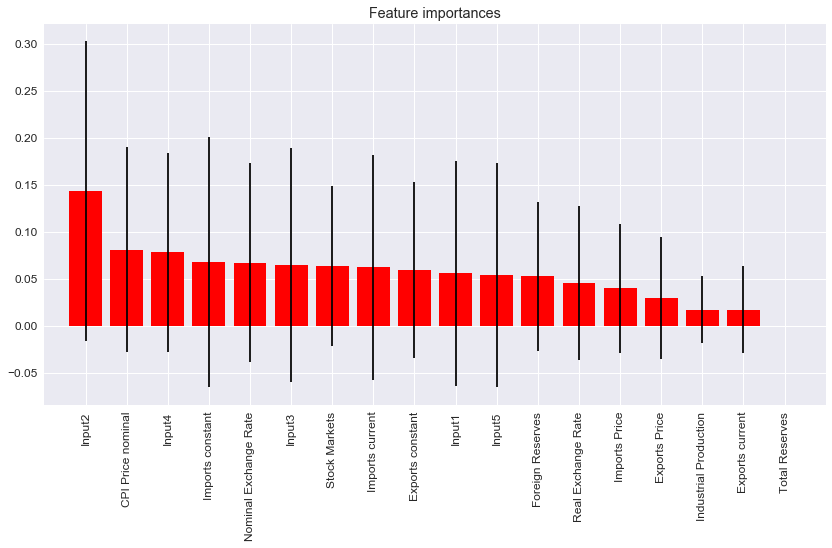

In [91]:
# Print the feature ranking
print("Feature ranking:")    
for f in range(df_in.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(14,7))
plt.title("Feature importances")
plt.bar(range(df_in.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.bar(range(df_in.shape[1]), importances[indices],color="r", align="center")
plt.xticks(range(df_in.shape[1]), feature_names[indices],fontsize=12)
plt.xlim([-1, df_in.shape[1]])
plt.xticks(rotation=90);
plt.show()

Plot the cumulative returns for model vs long

0.280013555401


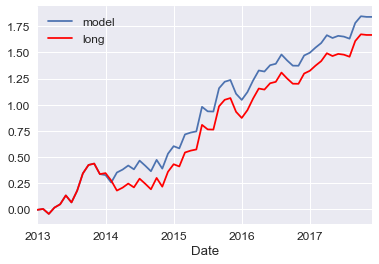

In [92]:
y_hat=est.best_estimator_.predict(df_in_oos)
print(np.corrcoef(df_tar_oos.T,y_hat.T)[0][1])
i=y_hat<0
cumul_eq=df_tar_oos.copy()
cumul_eq[i]=cumul_eq[i]*-1
cumul_eq.cumsum().plot(label='model')
ax=df_tar_oos.cumsum().plot(c='red', label='long')
ax.legend();

Although the model seems to show some promise (the blue line is above the red) this is likely to be just a random result.

Case Description 
OBJECTIVE: Create a predictive model for the Amazon stock (ticker AMZN). In the model include one or more indicators for the US (see data section below). Some hints to the task are:
•	Structure the project in a sound manner that follows best coding practices (i.e. follow the DRY and SoC principles for instance)
•	Points will be given for creative use of combining the two data sources
•	The data is on different time frequencies, it will be up to you to figure out how to handle that.
•	Choose an appropriate approach to model the time series
•	Write a document where you present any insights and visualizations you think are interesting in the data, include a writeup of the results of a back-test of your models
•	Put your code on GitHub and include a link to your code in the document
DATA
•	Sources:
o	https://www.quandl.com/data/WGEM-World-Bank-Global-Economic-Monitor/usage/quickstart/api
	Sign up for an API key to get access, and select one or more monthly indicators for the US
o	 https://www.alphavantage.co/documentation/
	Get your API key from the site and use the TIME_SERIES_DAILY_ADJUSTED API to get data for the AMZN symbol
•	Format: for the AMZN data use daily, adjusted close
•	Time-period: 01-01-2000 until today
EVALUATION
•	We will focus on your approach to solving the problem, and will not put much weight on the final model. A good model is preferable, but the approach will be weighted higher than the actual result.
•	The evaluation will be based on a combination of your understanding of financial modeling and technical capabilities in terms of structuring the code
DEADLINE
29hth of April, 23:59 – send the project to both case leaders.


In [278]:
shiller=pd.read_html('http://www.econ.yale.edu/~shiller/data/chapt26.html')
yr=pd.DataFrame((shiller[1][0][1]).split(),columns=['Year'])
sp=pd.DataFrame((shiller[0][1][2]).split(),columns=['stock_price'])
yr.drop(yr.index[-2:],inplace=True)
result = pd.concat([yr, sp], axis=1)
result.set_index('Year',inplace=True)
result=result.astype('float')